In [39]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, RandomForestRegressor, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, linear_model, neighbors, ensemble, tree
import statsmodels.api as sm
import statsmodels.formula.api as smf
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import pickle

warnings.filterwarnings('ignore')

os.environ['LOKY_MAX_CPU_COUNT'] = '4'
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Define the data types as a dictionary
dtypes = {
    'census_tract': 'float32',
    'action_taken': 'int32',
    'loan_type': 'int32',
    'lien_status': 'int32',
    'reverse_mortgage': 'int32',
    'open_end_line_of_credit': 'int32',
    'loan_amount': 'int32',
    'combined_loan_to_value_ratio': 'int32',
    'interest_rate': 'float32',
    'total_loan_costs': 'int32',
    'origination_charges': 'int32',
    'loan_term': 'int32',
    'negative_amortization': 'int32',
    'interest_only_payment': 'int32',
    'balloon_payment': 'int32',
    'other_nonamortizing_features': 'int32',
    'property_value': 'float32',
    'occupancy_type': 'int32',
    'manufactured_home_secured_property_type': 'int32',
    'manufactured_home_land_property_interest': 'int32',
    'total_units': 'int32',
    'income': 'float32',
    'debt_to_income_ratio': 'int32',
    'applicant_credit_score_type': 'int32',
    'co_applicant_credit_score_type': 'int32',
    'applicant_sex': 'int32',
    'co_applicant_sex': 'int32',
    'applicant_age': 'int32',
    'co_applicant_age': 'int32',
    'aus_1': 'int32',
    'applicant_race_1': 'float32',
    'applicant_race_2': 'float32',
    'co_applicant_race_1': 'float32',
    'co_applicant_race_2': 'float32',
    'applicant_ethnicity_1': 'float32',
    'co_applicant_ethnicity_1': 'float32'
}

In [3]:
# Read the CSV file with specified data types
df = pd.read_csv('10_all_numerical_32bit.csv', dtype=dtypes, low_memory=False)

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
random_state=42

In [6]:
# Convert 'action_taken' to binary
df_scaled['action_taken'] = df['action_taken'].map({1: 1, 3: 0})

# Split the data into features (X) and the binary target variable (y)
X = df_scaled.drop(['action_taken'], axis=1)
y = df_scaled['action_taken']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.11, random_state=random_state)

In [7]:
df_scaled['action_taken'].value_counts()

action_taken
0    77116
1    71505
Name: count, dtype: int64

# Logistic Regression

In [8]:
LR = LogisticRegression(max_iter = 1000)
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 
print(f"F1 score for validation: {f1_score(LR.predict(X_val), y_val)}")

The accuracy for training: 0.8256244707874683
The accuracy for validation: 0.8295308581564622
F1 score for validation: 0.8218827890330415


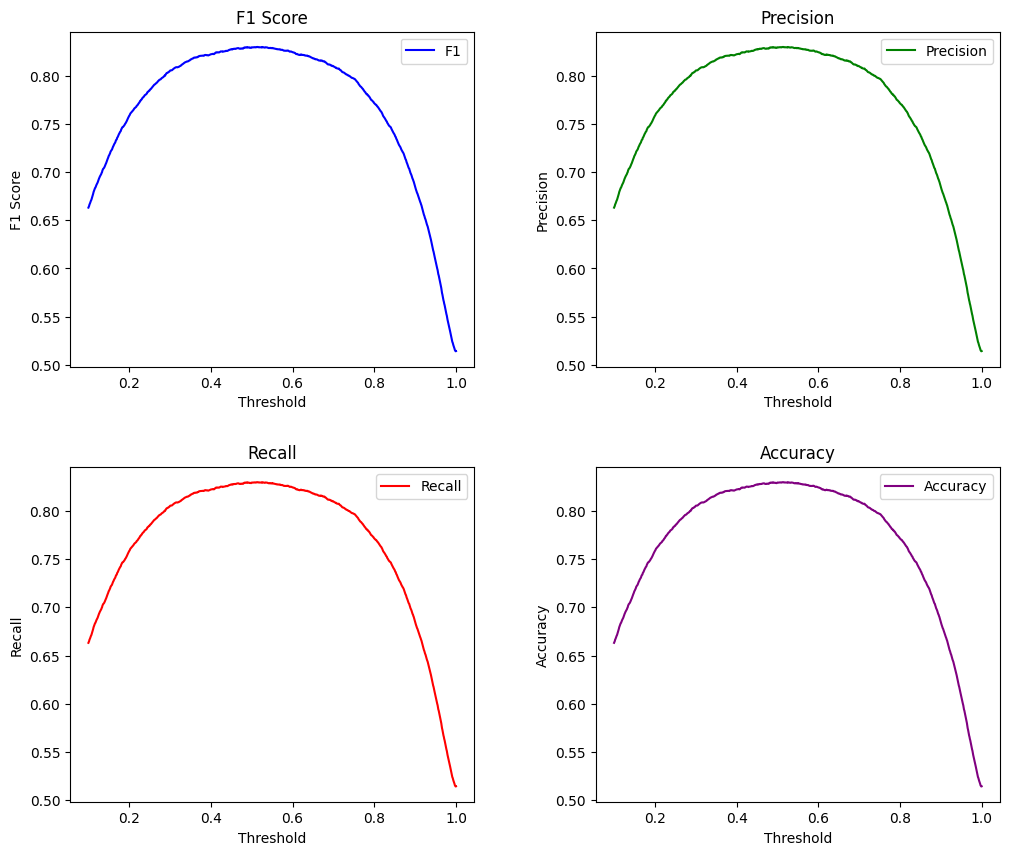

Logistic Regression Model best F1 score 0.830 at prob decision threshold >= 0.514


In [9]:
thresh_ps = np.linspace(.10, 1, 1000)
model_val_probs = LR.predict_proba(X_val)[:, 1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
best_f1_score, best_thresh_p = 0, 0  # Initialize best F1 score and threshold

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    prec_scores.append(precision_score(y_val, model_val_labels, average='micro'))
    rec_scores.append(recall_score(y_val, model_val_labels, average='micro'))
    f1 = f1_score(y_val, model_val_labels, average='micro')
    f1_scores.append(f1)
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_thresh_p = p

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Plot F1 score
axes[0, 0].plot(thresh_ps, f1_scores, label='F1', color='blue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')

# Plot Precision
axes[0, 1].plot(thresh_ps, prec_scores, label='Precision', color='green')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
axes[1, 0].plot(thresh_ps, rec_scores, label='Recall', color='red')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')

# Plot Accuracy
axes[1, 1].plot(thresh_ps, acc_scores, label='Accuracy', color='purple')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Accuracy')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

# Display the plots
plt.show()


print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


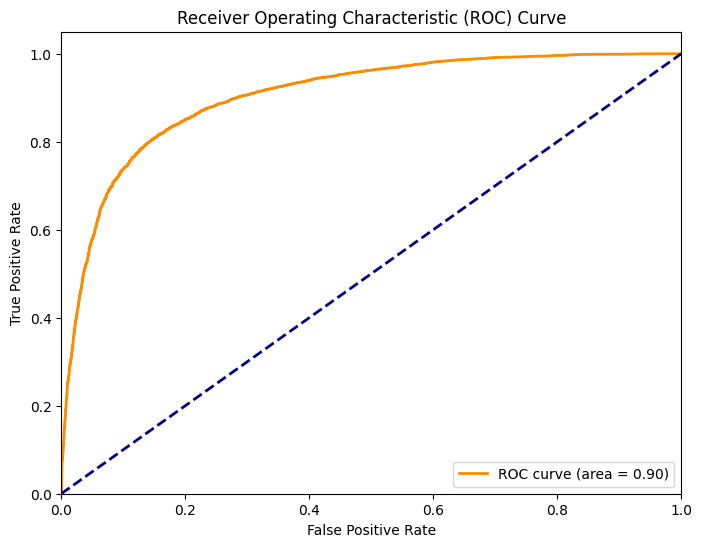

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
model_val_probs = LR.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [11]:
y_predict = (LR.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.8781,   Recall: 0.7156


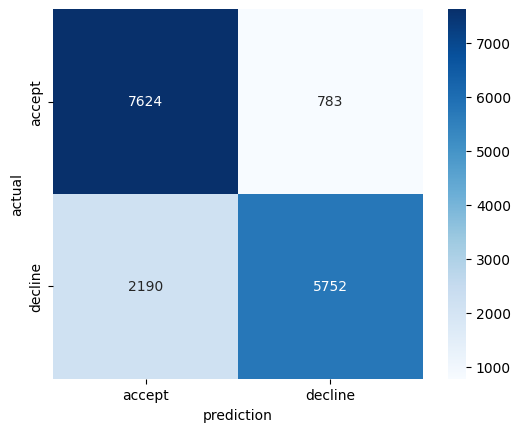

In [12]:
y_predict = (LR.predict_proba(X_val)[:, 1] >= 0.65)

fraud_confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(fraud_confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

# KNeighborsClassifier

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Fill missing values with mean (or any other strategy) and scale the data
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_val = imputer.transform(X_val)
X_val = scaler.transform(X_val)

# Then, you can fit the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))
print('F1_score for train: ', f1_score(knn.predict(X_train), y_train))
print('F1_score for validation: ', f1_score(knn.predict(X_val), y_val))


The accuracy for training :  0.9738644611104391
The accuracy for validation:  0.9530858156462169
F1_score for train:  0.9722349388397625
F1_score for validation:  0.9501138211382114


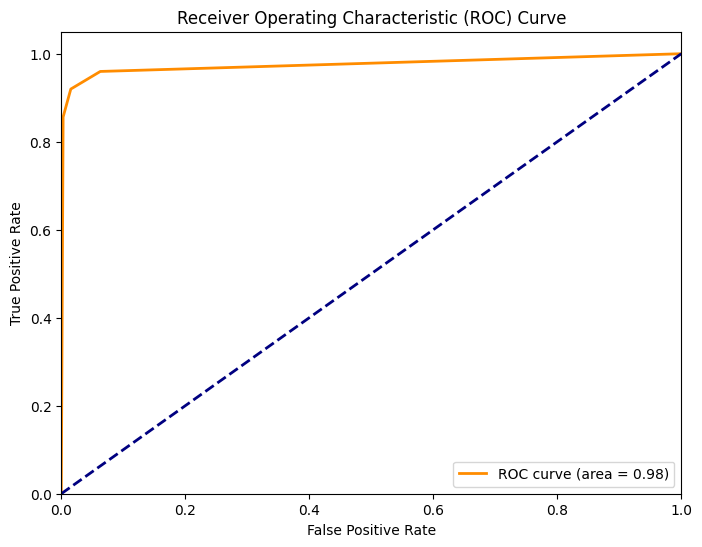

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
model_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
y_predict = (knn.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.9931,   Recall: 0.9522


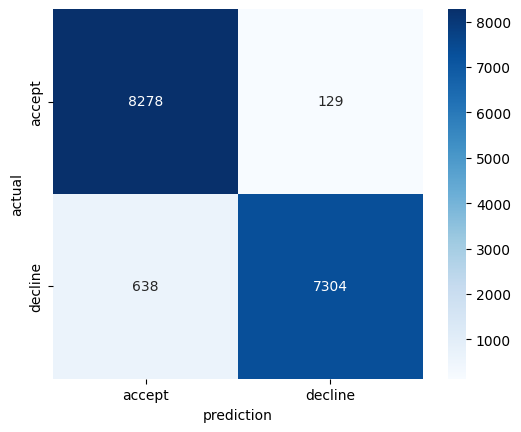

In [16]:
y_predict = (knn.predict_proba(X_val)[:, 1] >= 0.65)

fraud_confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(fraud_confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

# Naive Bayes

In [17]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))
print('f1_score for train: ',f1_score(Gaussian.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(Gaussian.predict(X_val), y_val))

The accuracy for training :  0.6057139833071247
The accuracy for validation:  0.6043183069300875
f1_score for train:  0.7090504376544622
f1_score for validation:  0.7105463331692693


# Ada Boost Classifier

In [18]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=random_state)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(AB_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(AB_CLF.predict(X_val), y_val))

The accuracy for training :  0.9953656102576509
The accuracy for validation:  0.9951679001773809
f1_score for train:  0.9951567154155506
f1_score for validation:  0.9950034785908544


# Stochastic Gradient Descent Algorithm

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(SG_PIP_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(SG_PIP_CLF.predict(X_val), y_val))

The accuracy for training :  0.8288829079472602
The accuracy for validation:  0.8334454706709891
f1_score for train:  0.8164761209762426
f1_score for validation:  0.8240387722132472


# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [21]:
xgb_model = xgb.XGBClassifier()

parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'silent': [1],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [8000, 9000, 10000],
    'missing': [-999],
    'seed': [1337],
    'eval_metric': ['logloss'],
}

# Add early stopping
early_stopping_rounds = 3

# Use 3-fold cross-validation
clf = GridSearchCV(xgb_model, parameters, n_jobs=3,
                   cv=KFold(n_splits=3, shuffle=True, random_state=random_state),
                   scoring='neg_log_loss',  
                   verbose=4, refit=True)


# Implement early stopping
eval_set = [(X_val, y_val)]
clf.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=early_stopping_rounds)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[17:31:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.53139
[1]	validation_0-logloss:0.44220
[2]	validation_0-logloss:0.36969
[3]	validation_0-logloss:0.32818
[4]	validation_0-logloss:0.27168
[5]	validation_0-logloss:0.21832
[6]	validation_0-logloss:0.17946
[7]	validation_0-logloss:0.14764
[8]	validation_0-logloss:0.12390
[9]	validation_0-logloss:0.10946
[10]	validation_0-logloss:0.09319
[11]	validation_0-logloss:0.07904
[12]	validation_0-logloss:0.06784
[13]	validation_0-logloss:0.06234
[14]	validation_0-logloss:0.05488
[15]	validation_0-logloss:0.04922
[16]	validation_0-logloss:0.04366
[17]	validation_0-logloss:0.03930
[18]	validation_0-logloss:0.03578
[19]	validation_0-logloss:0.03307
[20]	validation_0-logloss:0.03144
[21]	validation_0-logloss:0.02927
[22]	validation_0-logloss:0.02773
[23]	validation_0-logloss

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     int...
                                     random_state=None, ...),
             n_jobs=3,
             param_grid={'colsample_bytree': [0.7], 'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'missing': [-999], 'n_estimators': [8000, 9000, 10000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1337], 'silent': [1],
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_log_loss', verbose=4)

In [23]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [24]:
clf.best_params_

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 5,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.9}

In [27]:
gbm = xgb.XGBClassifier( 
    n_estimators=7500,
    max_depth=3,
    objective='binary:logistic',
    learning_rate=0.6,
    subsample=0.93,
    min_child_weight=5,
    colsample_bytree=0.75
)

eval_set = [(X_train, y_train), (X_val, y_val)]
fit_model = gbm.fit( 
    X_train, y_train, 
    eval_set=eval_set,
    eval_metric='error',
    early_stopping_rounds=50,
    verbose=False
)

print(accuracy_score(y_train, gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)))
print(accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))
print('f1_score for train:', f1_score(gbm.predict(X_train), y_train))
print('f1_score for validation:', f1_score(gbm.predict(X_val), y_val))

0.9964542760372566
0.9955348951006178
f1_score for train: 0.99630024060269
f1_score for validation: 0.9953905411378418


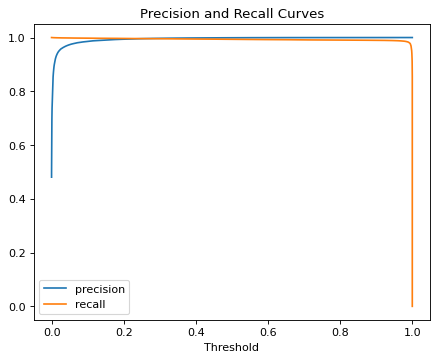

In [29]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, gbm.predict_proba(X_train)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [28]:
y_predict = (gbm.predict_proba(X_train)[:, 1] >= 0.59)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.9996,   Recall: 0.9925


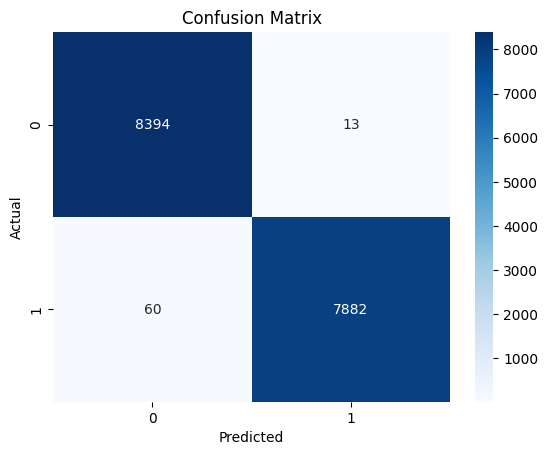

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the validation dataset
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels and titles
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()


# Pickle models

In [31]:

lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=random_state)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=random_state)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [32]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [33]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [34]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

lr_model score: 0.8274011128583525
lr_model score: 0.830264848002936
dt_model score: 0.9950858836337244
dt_model score: 0.9950455685363019
ADA_model score: 0.9953656102576509
ADA_model score: 0.9951679001773809
SGD_model score: 0.8305461473327689
SGD_model score: 0.8356474402104104


# voting classifer (HARD)

In [35]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=42)),
                             ('dt_model', DecisionTreeClassifier(max_depth=8)),
                             ('ADA_model', AdaBoostClassifier(random_state=42)),
                             ('SGD_model',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('sgdclassifier',
                                               SGDClassifier(max_iter=100))]))],
                 n_jobs=-1)

In [36]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

0.9063974234909883

In [37]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

0.9105755703712766

# Save model

In [ ]:
'''

with open('final_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
'''